# 训练模型
## 1. 单模型训练  
单模型训练, 我们采用的是keras库提供的InceptionV3, Xception, InceptionResNetV2三个模型

数据集下载：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

### 载入必要的库

In [2]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import h5py
import numpy as np
from tqdm import tqdm
import cv2
import math
import os
import datetime
import pydot
from matplotlib import pyplot as plt

/home/autel/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 定义检查路径函数

In [3]:
def check_path_gen():
    if not(os.path.exists('./Weights')):
        os.mkdir('Weights')
    if not(os.path.exists('./Tensor_log')):
        os.mkdir('Tensor_log')

### 定义剔除异常数据函数

In [4]:
dog_train_path = './Dataset/train/dog'
cat_train_path = './Dataset/train/cat'

def abnormal_data_reject():
    dog_train_list = os.listdir(dog_train_path)
    cat_train_list = os.listdir(cat_train_path)
    with open('./abnormal.txt', 'r') as f:
        while 1:
            line = f.readline()
            if not line:
                break
            img_name = line.replace('\n', '')
            if 'dog' in line:
                dog_train_list.remove(img_name)
            else:
                cat_train_list.remove(img_name)
    dog_train_list = [os.path.join(dog_train_path, f) for f in dog_train_list]
    cat_train_list = [os.path.join(cat_train_path, f) for f in cat_train_list]
    train_list = dog_train_list + cat_train_list

    return train_list

### 定义训练函数

In [5]:
def train_cat_dog(MODEL, image_size, preprocess_func):
    # hyper-parameters
    bs = 16

    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)

    # 搭建tranfer learning的最后一层
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.25)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input, x)
    model.compile(optimizer='adadelta',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # data generate
    n = all_train_list.__len__()
    X = np.zeros((n, image_size[0], image_size[1], 3), dtype=np.uint8)
    y = np.zeros((n, 1), dtype=np.uint8)
    X_file = 'X' + str(image_size[0]) + '.npy'
    y_file = 'y' + str(image_size[0]) + '.npy'

    if os.path.exists(X_file) and os.path.exists(y_file):
        X = np.load(X_file)
        y = np.load(y_file)
    else:
        for idx, img_name in tqdm(enumerate(all_train_list)):
            X[idx] = cv2.resize(cv2.imread(img_name), (image_size[0], image_size[1]))
            if 'dog' in img_name:
                y[idx] = 1
            else:
                y[idx] = 0
        np.save(X_file, X)
        np.save(y_file, y)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    train_generator = train_datagen.flow(X_train, y_train, batch_size=bs)
    val_generator = val_datagen.flow(X_valid, y_valid, batch_size=bs)

    # callbacks
    best_weights_path = os.path.join('./Weights', MODEL.__name__)
    if not(os.path.exists(best_weights_path)):
        os.mkdir(best_weights_path)
    best_weights_filepath = os.path.join(best_weights_path, 'best_weights')

    log_path = os.path.join('./Tensor_log', MODEL.__name__)
    if not (os.path.exists(log_path)):
        os.mkdir(log_path)

    earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
    saveBestModel = ModelCheckpoint(best_weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/math.e, verbose=1, patience=10, min_lr=0.0001)
    tensorboard = TensorBoard(log_dir=log_path)

    # 训练
    model.fit_generator(train_generator, steps_per_epoch=1000, epochs=8, validation_data=val_generator,
                        verbose=2, callbacks=[earlyStopping, saveBestModel, reduce_lr, tensorboard])
    # model.fit(X, y, batch_size=16, epochs=50, validation_split=0.1)
    model.save(MODEL.__name__ + '_cvd.h5')

### 执行训练过程, 统计训练时间并生成固化模型

In [6]:
check_path_gen()
all_train_list = abnormal_data_reject()

# tick tock start
starttime = datetime.datetime.now()
train_cat_dog(InceptionV3, (299, 299), inception_v3.preprocess_input)
endtimeV3 = datetime.datetime.now()

train_cat_dog(Xception, (299, 299), xception.preprocess_input)
endtimeXcep = datetime.datetime.now()

train_cat_dog(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)
endtimeIRV2 = datetime.datetime.now()

print('InceptionV3 train time %d seconds' % (endtimeV3-starttime).seconds)
print('Xception train time %d seconds' % (endtimeXcep-endtimeV3).seconds)
print('InceptionResNetV2 train time %d seconds' % (endtimeIRV2-endtimeXcep).seconds)

Epoch 1/8
 - 316s - loss: 0.1761 - acc: 0.9279 - val_loss: 0.1110 - val_acc: 0.9550

Epoch 00001: val_loss improved from inf to 0.11102, saving model to ./Weights/InceptionV3/best_weights
Epoch 2/8
 - 305s - loss: 0.0960 - acc: 0.9642 - val_loss: 0.0954 - val_acc: 0.9578

Epoch 00002: val_loss improved from 0.11102 to 0.09543, saving model to ./Weights/InceptionV3/best_weights
Epoch 3/8
 - 306s - loss: 0.0707 - acc: 0.9729 - val_loss: 0.0782 - val_acc: 0.9691

Epoch 00003: val_loss improved from 0.09543 to 0.07818, saving model to ./Weights/InceptionV3/best_weights
Epoch 4/8
 - 305s - loss: 0.0558 - acc: 0.9807 - val_loss: 0.0761 - val_acc: 0.9739

Epoch 00004: val_loss improved from 0.07818 to 0.07614, saving model to ./Weights/InceptionV3/best_weights
Epoch 5/8
 - 305s - loss: 0.0442 - acc: 0.9829 - val_loss: 0.2729 - val_acc: 0.9116

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 305s - loss: 0.0377 - acc: 0.9872 - val_loss: 0.0599 - val_acc: 0.9743

Epoch 00006: val_loss improv

## 2. 模型融合训练  
将三个模型特征提取出来, 融合在一起, 在加FC层和分类器, 利用集成学习方法训练更强大的模型

### 定义函数将三个模型的特征分别提取出来并保存成.h5文件

In [7]:
def write_gap(MODEL, image_size, lambda_func=None):
    # get model
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    # data generate
    n = all_train_list.__len__()
    X = np.zeros((n, image_size[0], image_size[1], 3), dtype=np.uint8)
    y = np.zeros((n, 1), dtype=np.uint8)
    X_file = 'X' + str(image_size[0]) + '.npy'
    y_file = 'y' + str(image_size[0]) + '.npy'

    if os.path.exists(X_file) and os.path.exists(y_file):
        X = np.load(X_file)
        y = np.load(y_file)
    else:
        for idx, img_name in tqdm(enumerate(all_train_list)):
            X[idx] = cv2.resize(cv2.imread(img_name), (image_size[0], image_size[1]))
            if 'dog' in img_name:
                y[idx] = 1
            else:
                y[idx] = 0
        np.save(X_file, X)
        np.save(y_file, y)

    train_data_gen = ImageDataGenerator()
    test_data_gen = ImageDataGenerator()

    train_generator = train_data_gen.flow(X, y, shuffle=False, batch_size=100)
    test_generator = test_data_gen.flow_from_directory("./Dataset/test2", image_size, shuffle=False
                                                       , batch_size=100, class_mode=None)
    # feature get
    train = model.predict_generator(train_generator, math.ceil(n/100))
    test = model.predict_generator(test_generator, int(test_generator.samples/100))
    with h5py.File("gap_%s.h5" % MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=y)

### 提取模型特征的执行过程

In [10]:
starttime = datetime.datetime.now()
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)
write_gap(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)
endtime = datetime.datetime.now()
print((endtime-starttime).seconds)

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
1357


### 训练融合模型并固化模型

In [11]:
X_train = []
X_test = []

starttime = datetime.datetime.now()

for filename in ["gap_InceptionV3.h5", "gap_Xception.h5", "gap_InceptionResNetV2.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

# 训练
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

log_path = './model_concat_tensor_log'
tensorboard = TensorBoard(log_dir=log_path)


model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2, callbacks=[tensorboard])
endtime = datetime.datetime.now()
print("model concat train time %d seconds" % (endtime-starttime).seconds)

# 模型保存
model.save('model_concat_cvd.h5')

/home/autel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 19918 samples, validate on 4980 samples
Epoch 1/8
19918/19918 [==============================] - 2s 116us/step - loss: 0.0694 - acc: 0.9810 - val_loss: 0.0166 - val_acc: 0.9952
Epoch 2/8
19918/19918 [==============================] - 1s 55us/step - loss: 0.0170 - acc: 0.9952 - val_loss: 0.0095 - val_acc: 0.9968
Epoch 3/8
19918/19918 [==============================] - 1s 56us/step - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0099 - val_acc: 0.9968
Epoch 4/8
19918/19918 [==============================] - 1s 54us/step - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0109 - val_acc: 0.9966
Epoch 5/8
19918/19918 [==============================] - 1s 56us/step - loss: 0.0108 - acc: 0.9964 - val_loss: 0.0072 - val_acc: 0.9968
Epoch 6/8
19918/19918 [==============================] - 1s 55us/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0071 - val_acc: 0.9966
Epoch 7/8
19918/19918 [==============================] - 1s 55us/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0090 - val_acc: 0.996

### 模型可视化
我们利用graphviz写好模型的结构, 观察输入和输出的特征数量和经过的结点

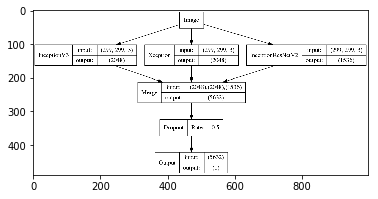

In [12]:
%matplotlib inline

(graph, ) = pydot.graph_from_dot_file('./graph_model_concat.dot')
graph.write('./graph_model_concat.png', format='png')
graph_img = cv2.imread('graph_model_concat.png')
b, g, r = cv2.split(graph_img)
img = cv2.merge([r, g, b])
plt.imshow(graph_img)